In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller 
from statsmodels.tsa.seasonal import seasonal_decompose

from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import temporal_train_test_split

import warnings
warnings.filterwarnings("ignore")

sns.set_style()

In [4]:
dados = pd.read_csv(r'D:\Blue EdTech\Bootcamp\dados\full_grouped.csv')

In [5]:
paises = ['Mexico', 'Argentina', 'Ecuador', 'Chile', 'Spain']
df = dados[dados['Country/Region'].isin(paises)]

In [8]:
df['Date'] = pd.to_datetime(df.Date, format="%Y-%m-%d")

Aplicando ADF

In [9]:
# observando numero de novos casos utilizando o metodo adFuller
df_temp = df.copy()

df_temp.set_index('Date', inplace=True)
# extrair apenas os valores
X = df_temp['New cases'].values

# aplicar ADF e imprimir o resultado
result = adfuller(X)
print('Dickey-Fuller Aumentado')
print('Teste Estatístico: {:.4f}'.format(result[0]))
print('Valor-p: {:.4f}'.format(result[1]))
print('Valores Críticos:')
for key, value in result[4].items():
	print('\t{}: {:.4f}'.format(key, value))

Dickey-Fuller Aumentado
Teste Estatístico: -1.2676
Valor-p: 0.6439
Valores Críticos:
	1%: -3.4375
	5%: -2.8647
	10%: -2.5684


Pelo o valor-p está maior que os valores criticos, a serie não é estacionária e será necessario transforma-lá em estacionária.

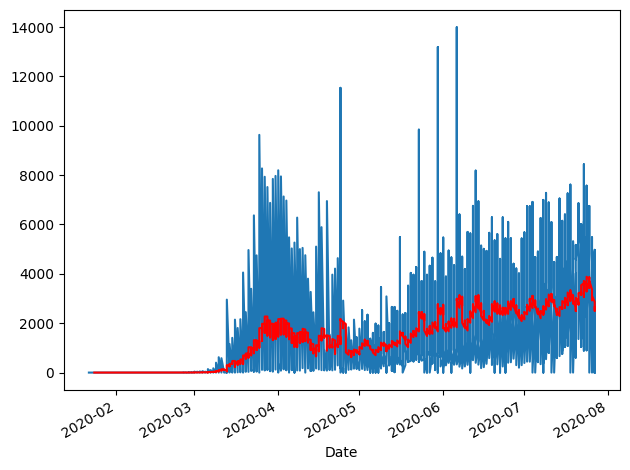

In [40]:
ma = df_temp['New cases'].rolling(12).mean()

fig, ax = plt.subplots()
df_temp['New cases'].plot(ax=ax, legend=False)
ma.plot(ax=ax, legend=False, color='r')
plt.tight_layout()

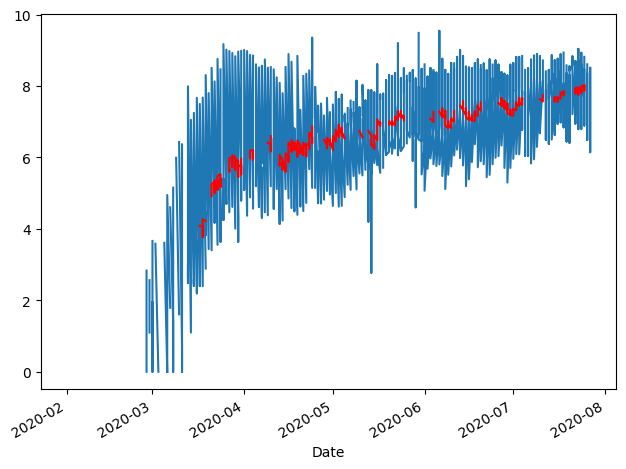

In [26]:
df_log = np.log(df_temp['New cases'])
ma_log = df_log.rolling(12).mean()

fig, ax = plt.subplots()
df_log.plot(ax=ax, legend=False)
ma_log.plot(ax=ax, legend=False, color='r')
plt.tight_layout()

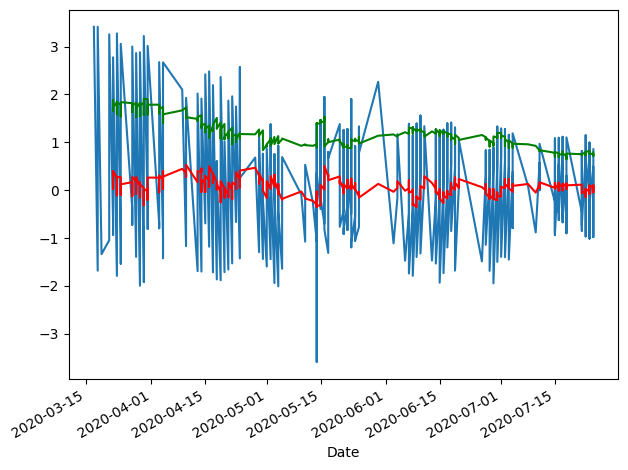

In [28]:
#subtrair média do log dos dados, iremos fazer a média em 12, pois iremos fazer anualmente
df_sub = (df_log - ma_log).dropna()
ma_sub = df_sub.rolling(12).mean()
#desvio padrão
std_sub = df_sub.rolling(12).std()

fig, ax = plt.subplots()
df_sub.plot(ax=ax, legend=False)
ma_sub.plot(ax=ax, legend=False, color='r')
std_sub.plot(ax=ax, legend=False, color='g')
plt.tight_layout()

In [35]:
#repetir o ADF
X_sub = df_sub.values

# aplicar ADF e imprimir o resultado
result_sub = adfuller(X_sub)
print('Dickey-Fuller Aumentado')
print('Teste Estatístico: {:.4f}'.format(result_sub[0]))
print('Valor-p: {:.10f}'.format(result_sub[1]))
print('Valores Críticos:')
for key, value in result_sub[4].items():
	print('\t{}: {:.4f}'.format(key, value))

Dickey-Fuller Aumentado
Teste Estatístico: -7.3847
Valor-p: 0.0000000001
Valores Críticos:
	1%: -3.4498
	5%: -2.8701
	10%: -2.5713


Para reduzir ainda mais o valor-p será usado a tecnica de diferenciação.

Dickey-Fuller Aumentado
Teste Estatístico: -9.6774
Valor-p: 0.0000000000
Valores Críticos:
	1%: -3.4498
	5%: -2.8701
	10%: -2.5713


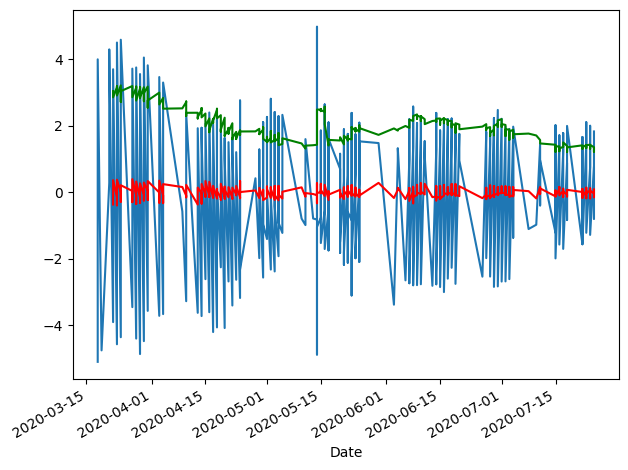

In [39]:
#Diferenciação

#aplicar diferenciação
df_diff = df_sub.diff(1)
ma_diff = df_diff.rolling(12).mean()
#desvio padrão
std_diff = df_diff.rolling(12).std()

#plotar a diferenciação
fig, ax = plt.subplots()
df_diff.plot(ax=ax, legend=False)
ma_diff.plot(ax=ax, legend=False, color='r')
std_diff.plot(ax=ax, legend=False, color='g')
plt.tight_layout()

#extrair apenas os valores e retirar os valores NA
X = df_diff.dropna().values

# aplicar ADF e imprimir o resultado
result_diff = adfuller(X)
print('Dickey-Fuller Aumentado')
print('Teste Estatístico: {:.4f}'.format(result_diff[0]))
print('Valor-p: {:.10f}'.format(result_diff[1]))
print('Valores Críticos:')
for key, value in result_sub[4].items():
	print('\t{}: {:.4f}'.format(key, value))


Agora a media está mais estacionaria e o valor-p está em zero, depois de transformar a serie em estacionaria será aplicada o ARIMA na proxima etapa.

## Modelo

In [ ]:
y = pd.Series(query_paises_cem['New cases'].values, query_paises_cem['Date'].values)

In [ ]:
y_train, y_test = temporal_train_test_split(y)

plot_series(y_train, y_test, labels=["y_train", "y_test"])

In [ ]:
covid = query_paises_cem[['New cases','New deaths']]

covid.plot(figsize=(9,4))
plt.show()

### Diferença entre os novos casos por dia

### Diferença entre os novos obitos por dia

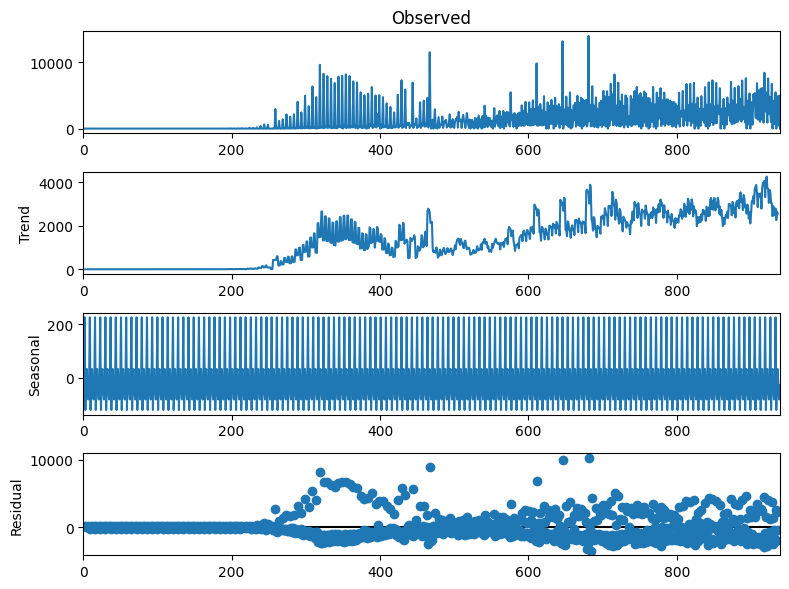

In [ ]:
novos_obitos = np.array(y)

# decompor por semana
result = seasonal_decompose(novos_obitos, model='additive', period=7)

fig = result.plot()
fig.set_size_inches((8, 6))

fig.tight_layout()
plt.show()

In [ ]:
# criando o modelo
auto_arima(covid['New deaths'],seasonal=True,m=7).summary()

# ajustando o modelo
# colocamos os parametros start_p e start_q em 0 para
# serem os valores iniciais de treino e colocamos os 
# parametros max_p e max_q nos valores finais. 
# m=7 que será de observacoes diária
stepwise_fit = auto_arima(covid['New deaths'], start_p=0, start_q=0, 
    max_p=6, max_q=3, m=7,
    seasonal=True,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True)

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=13424.230, Time=0.64 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=13465.868, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=13101.439, Time=0.52 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=12643.375, Time=0.98 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=13463.869, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=12594.243, Time=1.23 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=inf, Time=0.60 sec
 ARIMA(0,1,1)(2,0,1)[7] intercept   : AIC=12558.403, Time=2.18 sec
 ARIMA(0,1,1)(2,0,0)[7] intercept   : AIC=12618.693, Time=1.61 sec
 ARIMA(0,1,1)(2,0,2)[7] intercept   : AIC=inf, Time=4.28 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=12544.592, Time=3.31 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=12572.691, Time=2.24 sec
 ARIMA(0,1,0)(1,0,2)[7] intercept   : AIC=13269.561, Time=1.05 sec
 ARIMA(1,1,1)(1,0,2)[7] intercept   :

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                  940
Model:             SARIMAX(2, 1, 1)x(2, 0, [1, 2], 7)   Log Likelihood               -6151.704
Date:                                Fri, 02 Dec 2022   AIC                          12321.408
Time:                                        19:58:49   BIC                          12365.012
Sample:                                             0   HQIC                         12338.031
                                                - 940                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.7962      0.911     -1.971      0.049      -3.582      -0.010
ar.L1          0.0508      0.031      1.638      0.101      -0.010       0.112
ar.L2         -0.3259      0.023    -14.009      0.000      -0.371      -0.280
ma.L1         -0.9041      0.019    -47.704      0.000      -0.941      -0.867
ar.S.L7        0.6391      0.021     31.068      0.000       0.599       0.679
ar.S.L14      -0.9347      0.018    -52.214      0.000      -0.970      -0.900
ma.S.L7       -0.7305      0.038    -19.367      0.000      -0.804      -0.657
ma.S.L14       0.7581      0.036     21.300      0.000       0.688       0.828
sigma2      3.105e+04    467.072     66.473      0.000    3.01e+04     3.2e+04
===================================================================================
Ljung-Box (L1) (Q):                  17.37   Jarque-Bera (JB):             30841.73
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              18.15   Skew:                            -0.63
Prob(H) (two-sided):                  0.00   Kurtosis:                        31.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
cut = int(covid.shape[0] * 0.80)
train = covid.iloc[:cut]
test = covid.iloc[cut:]

# modelo
model = SARIMAX(train['New deaths'],order=(6,1,1),seasonal_order=(2,0,[1,2],7))
model_fit = model.fit()
model_fit.summary()

C:\Users\brodr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\brodr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\brodr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\brodr\AppData\Local\Packages\PythonSoftwar

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                             New deaths   No. Observations:                  752
Model:             SARIMAX(6, 1, 1)x(2, 0, [1, 2], 7)   Log Likelihood               -4736.458
Date:                                Fri, 02 Dec 2022   AIC                           9496.917
Time:                                        20:01:09   BIC                           9552.373
Sample:                                             0   HQIC                          9518.284
                                                - 752                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0535      0.094     -0.566      0.571      -0.238       0.132
ar.L2         -0.2048      0.041     -5.055      0.000      -0.284      -0.125
ar.L3         -0.1826      0.042     -4.308      0.000      -0.266      -0.100
ar.L4         -0.1623      0.072     -2.244      0.025      -0.304      -0.021
ar.L5          0.5289      0.049     10.742      0.000       0.432       0.625
ar.L6         -0.0869      0.081     -1.078      0.281      -0.245       0.071
ma.L1         -0.9435      0.033    -28.705      0.000      -1.008      -0.879
ar.S.L7        0.5031      0.171      2.935      0.003       0.167       0.839
ar.S.L14      -0.8549      0.148     -5.795      0.000      -1.144      -0.566
ma.S.L7       -0.4786      0.205     -2.336      0.019      -0.880      -0.077
ma.S.L14       0.7696      0.185      4.151      0.000       0.406       1.133
sigma2      1.879e+04    249.334     75.373      0.000    1.83e+04    1.93e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):            303555.64
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):           41104.05   Skew:                            -1.92
Prob(H) (two-sided):                  0.00   Kurtosis:                       101.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
df_temp = pd.read_csv(r'D:\Blue EdTech\Bootcamp\dados\owid-covid-data.csv')

In [ ]:
df_temp['date'] = pd.to_datetime(df_temp['date'], format="%Y-%m-%d")

In [ ]:
x_data = df_temp['date']
y_obitos = df_temp['new_deaths']

In [ ]:
spain_temp = df_temp[df_temp.location == 'Spain']
mexico_temp = df_temp[df_temp.location == 'Mexico']
argentina_temp = df_temp[df_temp.location == 'Argentina']
ecuador_temp = df_temp[df_temp.location == 'Ecuador']
chile_temp = df_temp[df_temp.location == 'Chile']

<function matplotlib.pyplot.show(close=None, block=None)>

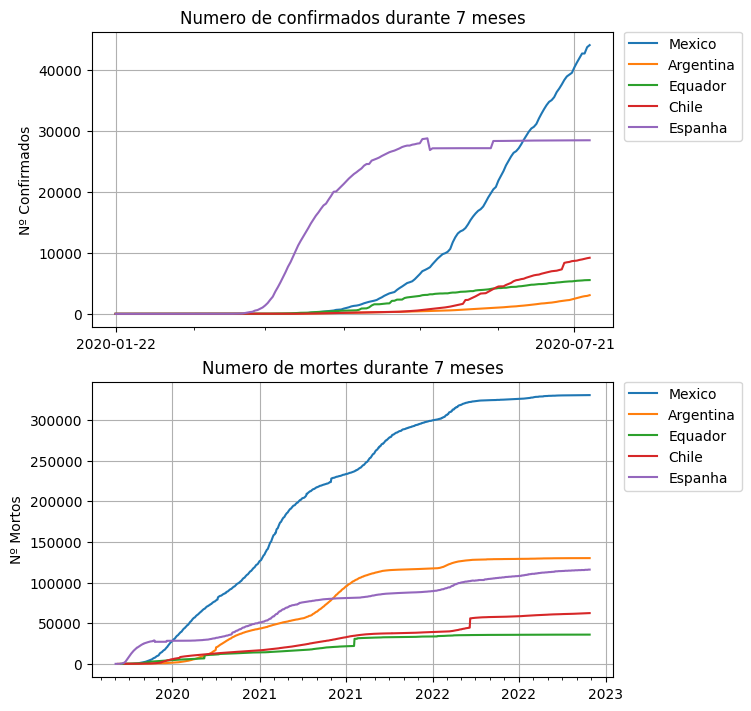

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(7.4, 7), constrained_layout=True)

# Ajustando data
for ax in axs:
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    ax.grid(True)

# Grafico de linhas - Confirmados
ax = axs[0]
ax.set_title(r'Numero de confirmados durante 7 meses')
ax.set_ylabel(r'Nº Confirmados')
ax.plot('Date', 'Deaths', data=mexico, label= 'Mexico')
ax.plot('Date', 'Deaths', data=argentina, label= 'Argentina')
ax.plot('Date', 'Deaths', data=ecuador, label= 'Equador')
ax.plot('Date', 'Deaths', data=chile, label= 'Chile')
ax.plot('Date', 'Deaths', data=spain, label= 'Espanha')
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

# Grafico de linhas - Mortes
ax = axs[1]
ax.set_title(r'Numero de mortes durante 7 meses')
ax.set_ylabel(r'Nº Mortos')
ax.plot('date', 'total_deaths', data=mexico_temp, label= 'Mexico')
ax.plot('date', 'total_deaths', data=argentina_temp, label= 'Argentina')
ax.plot('date', 'total_deaths', data=ecuador_temp, label= 'Equador')
ax.plot('date', 'total_deaths', data=chile_temp, label= 'Chile')
ax.plot('date', 'total_deaths', data=spain_temp, label= 'Espanha')
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)


plt.show

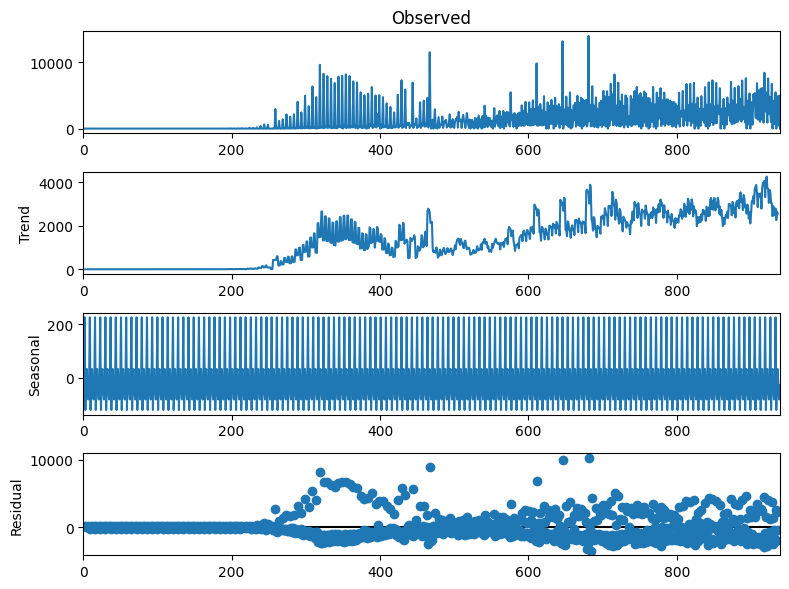

In [ ]:
novos_casos = np.array(y)

# decompor por semana
result = seasonal_decompose(novos_casos, model='additive', period=7)

fig = result.plot()
fig.set_size_inches((8, 6))

fig.tight_layout()
plt.show()

In [ ]:
#!pip install pmdarima

In [ ]:
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
# criando o modelo
auto_arima(covid['New cases'],seasonal=True,m=7).summary()

# ajustando o modelo
# colocamos os parametros start_p e start_q em 0 para
# serem os valores iniciais de treino e colocamos os 
# parametros max_p e max_q nos valores finais. 
# m=7 que será de observacoes diária
stepwise_fit = auto_arima(covid['New cases'], start_p=0, start_q=0, 
    max_p=6, max_q=3, m=7,
    seasonal=True,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True)

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=17519.376, Time=1.61 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=17696.018, Time=0.12 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=17164.382, Time=0.47 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=inf, Time=1.18 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=17694.018, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=17170.874, Time=0.25 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=17084.491, Time=1.18 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=16930.207, Time=3.37 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=17068.265, Time=0.57 sec
 ARIMA(1,1,0)(2,0,2)[7] intercept   : AIC=16740.685, Time=3.13 sec
 ARIMA(1,1,0)(1,0,2)[7] intercept   : AIC=16932.776, Time=3.45 sec
 ARIMA(0,1,0)(2,0,2)[7] intercept   : AIC=16661.226, Time=4.32 sec
 ARIMA(0,1,0)(1,0,2)[7] intercept   : AIC=17297.347, Time=2.70 sec
 ARIMA(0,1,0)(2,0,1)[7] intercept   : AIC=17025.094, Time=2.87 sec
 ARIMA(0,1,1)(2,0,2)[7] i

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                  940
Model:             SARIMAX(6, 1, 1)x(2, 0, [1, 2], 7)   Log Likelihood               -7812.491
Date:                                Fri, 02 Dec 2022   AIC                          15648.981
Time:                                        18:23:36   BIC                          15707.119
Sample:                                             0   HQIC                         15671.145
                                                - 940                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0658      0.067     -0.978      0.328      -0.198       0.066
ar.L2         -0.2108      0.036     -5.889      0.000      -0.281      -0.141
ar.L3         -0.1325      0.048     -2.785      0.005      -0.226      -0.039
ar.L4         -0.1369      0.054     -2.536      0.011      -0.243      -0.031
ar.L5          0.5595      0.039     14.221      0.000       0.482       0.637
ar.L6         -0.0750      0.061     -1.221      0.222      -0.195       0.045
ma.L1         -0.9501      0.022    -44.086      0.000      -0.992      -0.908
ar.S.L7        0.6284      0.032     19.671      0.000       0.566       0.691
ar.S.L14      -0.9396      0.026    -36.649      0.000      -0.990      -0.889
ma.S.L7       -0.5477      0.054    -10.208      0.000      -0.653      -0.443
ma.S.L14       0.7981      0.049     16.450      0.000       0.703       0.893
sigma2       1.12e+06   2.35e+04     47.665      0.000    1.07e+06    1.17e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):             54439.23
Prob(Q):                              0.71   Prob(JB):                         0.00
Heteroskedasticity (H):               8.51   Skew:                             2.99
Prob(H) (two-sided):                  0.00   Kurtosis:                        39.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
cut = int(covid.shape[0] * 0.80)
train = covid.iloc[:cut]
test = covid.iloc[cut:]

# modelo
model = SARIMAX(train['New cases'],order=(6,1,1),seasonal_order=(2,0,[1,2],7))
model_fit = model.fit()
model_fit.summary()

C:\Users\brodr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\brodr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\brodr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\brodr\AppData\Local\Packages\PythonSoftwar

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                              New cases   No. Observations:                  752
Model:             SARIMAX(6, 1, 1)x(2, 0, [1, 2], 7)   Log Likelihood               -6279.807
Date:                                Fri, 02 Dec 2022   AIC                          12583.614
Time:                                        18:25:33   BIC                          12639.071
Sample:                                             0   HQIC                         12604.981
                                                - 752                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0849      0.095     -0.898      0.369      -0.270       0.100
ar.L2         -0.2033      0.047     -4.306      0.000      -0.296      -0.111
ar.L3         -0.1543      0.047     -3.269      0.001      -0.247      -0.062
ar.L4         -0.1724      0.064     -2.704      0.007      -0.297      -0.047
ar.L5          0.5757      0.047     12.264      0.000       0.484       0.668
ar.L6         -0.1119      0.090     -1.236      0.216      -0.289       0.066
ma.L1         -0.9442      0.029    -33.082      0.000      -1.000      -0.888
ar.S.L7        0.3266      0.055      5.989      0.000       0.220       0.434
ar.S.L14      -0.8679      0.059    -14.602      0.000      -0.984      -0.751
ma.S.L7       -0.1783      0.054     -3.313      0.001      -0.284      -0.073
ma.S.L14       0.9087      0.050     18.074      0.000       0.810       1.007
sigma2      1.229e+06   3.54e+04     34.734      0.000    1.16e+06     1.3e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.21   Jarque-Bera (JB):             41168.61
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):            1554.76   Skew:                             3.00
Prob(H) (two-sided):                  0.00   Kurtosis:                        38.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Decomposição da serie temporal

C:\Users\brodr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


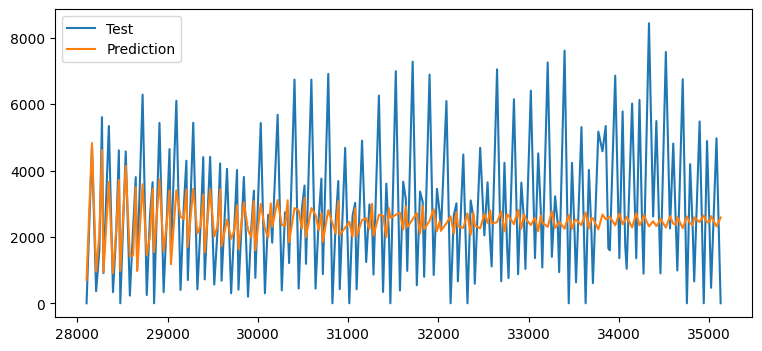

In [ ]:
start = train.shape[0]
end   = covid.shape[0] - 1

pred = model_fit.predict(start=start, end=end, dynamic=False, typ='levels')
pred.index = test.index

plt.figure(figsize=(14,10))
test['New cases'].plot(legend=True, label='Test')
pred.plot(legend=True, label='Prediction', figsize=(9,4))
plt.show()

Comparando a serie verdadeira com a serie predita

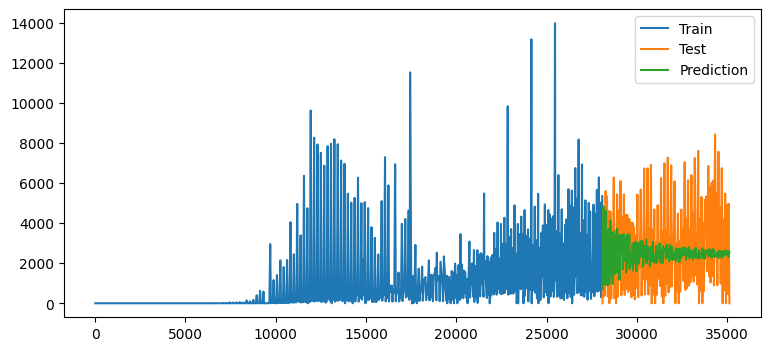

In [ ]:
plt.figure(figsize=(14,10))
train['New cases'].plot(legend=True, label='Train')
test['New cases'].plot(legend=True, label='Test')
pred.plot(legend=True, label='Prediction', figsize=(9,4))
plt.show()